In [1]:
# -*- encoding: utf-8 -*-
""" Application 2 of Module 1 - Analyze the connectivity of a computer network as it undergoes a cyber-attack """

import urllib2
import random
import time
import math
import numpy as np
import _03_Project_2 as pro2
import alg_upa_trial as upa
import matplotlib.pyplot as plt

In [2]:
# PROVIDED CODE
NETWORK_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_rf7.txt"

def load_graph(graph_url):
    """ Function that loads a graph given the URL for a text representation of the graph. Returns a dictionary that models a graph """
    graph_file = urllib2.urlopen(graph_url)
    graph_text = graph_file.read()
    graph_lines = graph_text.split('\n')
    graph_lines = graph_lines[: -1]

    print "Loaded graph with", len(graph_lines), "nodes"

    answer_graph = {}
    for line in graph_lines:
        neighbors = line.split(' ')
        node = int(neighbors[0])
        answer_graph[node] = set([])
        for neighbor in neighbors[1: -1]:
            answer_graph[node].add(int(neighbor))

    return answer_graph

def copy_graph(graph):
    """ Make a copy of a graph """
    new_graph = {}
    for node in graph:
        new_graph[node] = set(graph[node])
    return new_graph

def delete_node(ugraph, node):
    """ Delete a node from an undirected graph """
    neighbors = ugraph[node]
    ugraph.pop(node)
    for neighbor in neighbors:
        ugraph[neighbor].remove(node)

def targeted_order(ugraph):
    """ Compute a targeted attack order consisting of nodes of maximal degree. Returns: A list of nodes """
    new_graph = copy_graph(ugraph)  # copy the graph

    order = []
    while len(new_graph) > 0:  # the main loop will run 'n' times, and the 'for' loop below runs 'n' times, so this gives us O(n^2)
        max_degree = -1
        for node in new_graph:  # this loop is for finding the node with the most connections until there is none left
            if len(new_graph[node]) > max_degree:
                max_degree = len(new_graph[node])
                max_degree_node = node

        neighbours = new_graph[max_degree_node]   # this part is for deleting the most connected node and its edges
        new_graph.pop(max_degree_node)
        for neighbour in neighbours:
            new_graph[neighbour].remove(max_degree_node)  # if we also count this loop, then we need to add 'm' to running time, as this operates on edges, so in total we get O(n^2 + m)

        order.append(max_degree_node)
    return order

Loaded graph with 1239 nodes


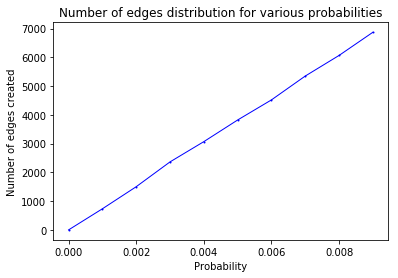

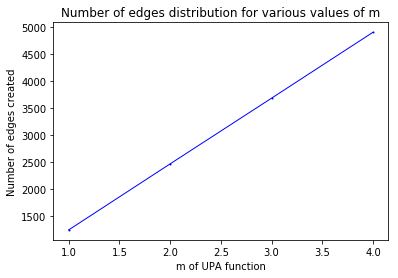

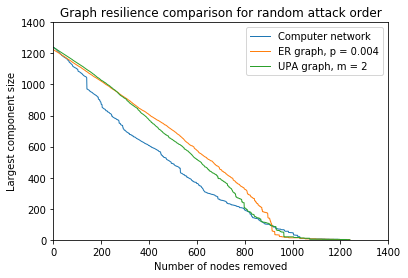

In [3]:
# QUESTION 1
# To begin our analysis, we will examine the resilience of the computer network under an attack in which servers are chosen at random.
# We will then compare the resilience of the network to the resilience of ER and UPA graphs of similar size.

# Some helper functions:
def make_complete_graph(num_nodes):
    """ Takes the number of nodes 'num_nodes' and returns a dictionary corresponding to a complete directed and undirected graph with the specified number of nodes """
    complete_graph = {}
    all_nodes = range(num_nodes)  # we first create all possible edges that we are going to apply to each node
    for node in range(num_nodes):
        complete_graph[node] = set(all_nodes) - set([node])  # this is the correction preventing edging to itself
    return complete_graph

def compute_edges(digraph):
    return sum(map(len, digraph.values())) / 2

def random_ugraph(num_nodes, probability):
    """ Function for creating a random undirected graphs """
    ugraph = {}
    for i in range(num_nodes):  # we use two loops here to simulate an interaction between every two nodes (except for interacting with itself)
        for j in range(i, num_nodes):
            if j not in ugraph:  # this is supposed to be O(1) operation, due to hashing of the keys
                ugraph[j] = set()  # we don't really have to create ugraph[i] as the first created key is always going to be 0
            if random.random() < probability and i != j:
                ugraph[i].add(j)
                ugraph[j].add(i)
    return ugraph

def UPA(n, m):
    assert 1 <= m <= n
    ugraph = make_complete_graph(m)  # we first make a complete undirected graph
    upa_obj = upa.UPATrial(m)
    for i in range(m, n):
        neighbours = upa_obj.run_trial(m)
        ugraph[i] = neighbours  # each time we call 'run_trial' we use the constant amount of new edges 'm'
        for neighbour in neighbours:
            ugraph[neighbour].add(i)
    return ugraph

def random_order(ugraph):
    nodes = list(ugraph.keys())
    random.shuffle(nodes)
    return nodes


def run_question_1():
    computer_network = (load_graph(NETWORK_URL))
    total_nodes = len(computer_network)  # 1239
    total_edges = compute_edges(computer_network)  # 3047

    # 1.1 To begin, you should determine the probability 'p' such that the ER graph computed using this edge probability has approximately the same number of edges as the computer network.
    # (Your choice for 'p' should be consistent with considering each edge in the undirected graph exactly once, not twice.)
    plt.title("Number of edges distribution for various probabilities")
    plt.xlabel("Probability")
    plt.ylabel("Number of edges created")
    x = []; y = []

    for probability in np.arange(0, 0.01, 0.001):
        x.append(probability)
        y.append(compute_edges(random_ugraph(total_nodes, probability)))  # here we check the number of edges we can get for a given probability

    plt.plot(x, y, color='blue', marker='.', linestyle='-', linewidth=1, markersize=2)  # a non-logarithmic version where we can see how the number of edges changes as we change probability
    plt.show()  # this plot will show us that the closes to 3047 edges is probability equal to 0.004


    # 1.2 Likewise, you should compute an integer 'm' such that the number of edges in the UPA graph is close to the number of edges in the computer network. Remember that all three graphs being analyzed in this
    # Application should have the same number of nodes and approximately the same number of edges.
    plt.title("Number of edges distribution for various values of m")
    plt.xlabel("m of UPA function")
    plt.ylabel("Number of edges created")
    x = []; y = []

    for m in range(1, 5):
        x.append(m)
        y.append(compute_edges(UPA(total_nodes, m)))  # here we check the number of edges we can get for a given 'm'

    plt.plot(x, y, color='blue', marker='.', linestyle='-', linewidth=1, markersize=2)  # a non-logarithmic version where we can see how the number of edges changes as we change probability
    plt.show()  # this plot will show us that the closes to 3047 edges is m equal to either 2 or 3


    # 1.3 Once you have computed the resilience for all three graphs, plot the results as three curves combined in a single standard plot (not log/log). Use a line plot for each curve. The horizontal axis for your single plot
    #  be the the number of nodes removed (ranging from zero to the number of nodes in the graph) while the vertical axis should be the size of the largest connect component in the graphs resulting from the node removal.
    plt.title("Graph resilience comparison for random attack order")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("Largest component size")
    plt.axis([0, 1400, 0, 1400])
    p = 0.004
    m = 2
    plots = [(computer_network, "Computer network"), (random_ugraph(total_nodes, p), "ER graph, p = " + str(p)), (UPA(total_nodes, m), "UPA graph, m = " + str(m))]

    for graph, label_on_plot in plots:
        y = pro2.compute_resilience(graph, random_order(graph))  # since the 'compute_resilience' procedure already outputs the correct order we don't really have to do anything extra
        plt.plot(y, linewidth=1, label=label_on_plot)

    plt.legend()
    plt.show()  # this plot will show us that for three similar graphs (same no. of nodes and edges) the resilience of the graph is alike

run_question_1()

Loaded graph with 1239 nodes
For ['computer network', 'ER', 'UPA']:
The biggest connected components after removal of 20% of nodes, with 992 nodes remaining: [904, 974, 962]
The % of connected components removed after removal of 20% of nodes: ['91%', '98%', '97%']


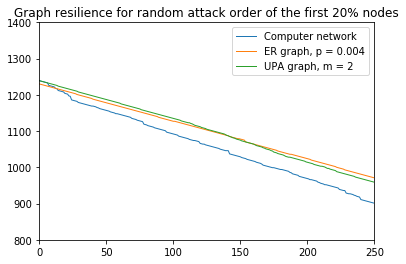

In [4]:
# QUESTION 2
# Consider removing a significant fraction of the nodes in each graph using random_order. We will say that a graph is resilient under this type of attack if the size of its largest connected component is
# roughly (within ~25%) equal to the number of nodes remaining, after the removal of each node during the attack.
# Examine the shape of the three curves from your plot in Question 1. Which of the three graphs are resilient under random attacks as the first 20% of their nodes are removed?
# Note that there is no need to compare the three curves against each other in your answer to this question.
def run_question_2():
    plt.title("Graph resilience for random attack order of the first 20% nodes")
    computer_network = (load_graph(NETWORK_URL))
    total_nodes = len(computer_network)  # 1239
    proc20 = total_nodes / 5  # 247 - this is the amount of nodes to be removed during the test
    nodes_remaining = total_nodes - proc20
    plt.axis([0, 250, 800, 1400])
    p = 0.004
    m = 2

    highest_cc = []
    plots = [(computer_network, "Computer network"), (random_ugraph(total_nodes, p), "ER graph, p = " + str(p)), (UPA(total_nodes, m), "UPA graph, m = " + str(m))]

    for graph, label_on_plot in plots:
        data = (pro2.compute_resilience(graph, random_order(graph)))  # since the 'compute_resilience' procedure already outputs the correct order we don't really have to do anything extra
        highest_cc.append(data[proc20])  # here we calculate the biggest remaining groups for the percentage comparison
        plt.plot(data, linewidth=1, label=label_on_plot)

    print "For ['computer network', 'ER', 'UPA']:"
    print "The biggest connected components after removal of 20% of nodes, with", nodes_remaining, "nodes remaining:", highest_cc
    print "The % of connected components removed after removal of 20% of nodes:", ["{0:.0%}".format(cc / float(nodes_remaining)) for cc in highest_cc]  # values must be ~equal to the number of nodes remaining
    plt.legend()
    plt.show()

run_question_2()

# As per calculated data below, the 'computer network' graph is not resilient (highest component loss went above 25%). The other graphs are resilient under random attack.
# For ['computer network', 'ER', 'UPA']:
# The biggest connected components after removal of 20% of nodes, with 992 nodes remaining: [820, 981, 969]
# The % of connected components removed after removal of 20% of nodes: ['83%', '99%', '98%']

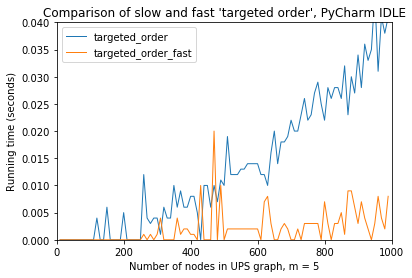

For total of 990 nodes there are 4874 edges
Time used on the slow(n^2) and fast(n+m) solution for 1000 nodes: [0.0409998893737793, 0.007999897003173828] The slow/fast ratio is: 5.12505215474


In [5]:
# QUESTION 3
# In the next three problems, we will consider attack orders in which the nodes being removed are chosen based on the structure of the graph. A simple rule for these targeted attacks is to always remove a node
# of maximum (highest) degree from the graph. Observe that 'targeted_order' continuously updates 'ugraph' and always computes a node of maximum degree with respect
# to this updated graph. The output of targeted_order is a sequence of nodes that can be used as input to 'compute_resilience'.
# For this question, your task is to implement fast_targeted_order and then analyze the running time of these two methods on UPA graphs of size n with m=5. Your analysis should be both mathematical and empirical and include the following:
# - Determine big-O bounds of the worst-case running times of 'targeted_order' and 'fast_targeted_order' as a function of the number of nodes n in the UPA graph.
# - Compute a plot comparing the running times of these methods on UPA graphs of increasing size.
# Since the number of edges in these UPA graphs is always less than 5n (due to the choice of m=5), your big-O bounds for both functions should be expressions in n. You should also assume that the all of the set
# operations used in 'fast_targeted_order' are O(1). Next, run these two functions on a sequence of UPA graphs with n in range(10,1000,10) and m=5 and use the time module to compute the running times of these functions.
def targeted_order_fast(ugraph):
    """ Compute a targeted attack order consisting of nodes of maximal degree. Returns: A list of nodes """
    ugraph = copy_graph(ugraph)  # copy the graph
    n = len(ugraph)
    degree_sets = [set([]) for nodes in range(n)]  # first we make a LIST to store all the node degrees from the least[0] to the most[n-1] connected

    for key in ugraph.keys():
        degree = len(ugraph[key])  # in undirected graph the sum of neighbours is the degree of the node
        degree_sets[degree].add(key)

    order = []
    for k in range(n - 1, -1, -1):  # now we scan 'degree_sets' from right to left side to start with the most connected components
        while degree_sets[k]:  # since there may be many nodes with the same level of connections wee need to scan them all
            node = degree_sets[k].pop()  # this is the normal process of removing the nodes
            for neighbour in ugraph[node]:  # this loop will update the neighbours of the removed node in the 'degree_sets'
                degree = len(ugraph[neighbour])  # in order to find the neighbour in 'degree_sets' we must find its degree
                degree_sets[degree].remove(neighbour)
                degree_sets[degree - 1].add(neighbour)  # then we move that neighbour one level down
            order.append(node)  # since we are using a LIST, we don't really need 'i'
            delete_node(ugraph, node)  # we also remove that node from the graph

    return order


def run_question_3():
    m = 5  # the 'm' starting parameter for a graph that limits the amount of nodes was given by tutor. It limits the graph edges to be n * 5 in this case
    total_range = 1000  # manipulate the range here
    answers = []  # list for storing the final running times
    upa_graph = {}
    x = []; y1 = []; y2 = []

    for n in range(10, total_range, 10):
        upa_graph = UPA(n, m)
        x.append(n)

        start = time.time()
        dummy_y = targeted_order(upa_graph)
        end = time.time()
        y1.append(end - start)

        start = time.time()
        dummy_y = targeted_order_fast(upa_graph)
        end = time.time()
        y2.append(end - start)

    answers.append(y1[-1])
    answers.append(y2[-1])
    plt.plot(x, y1, x, y2, linewidth=1)

    plt.title("Comparison of slow and fast 'targeted order', PyCharm IDLE")
    plt.xlabel("Number of nodes in UPS graph, m = 5")
    plt.ylabel("Running time (seconds)")
    plt.legend(["targeted_order", "targeted_order_fast"])
    plt.axis([0, total_range, 0, 0.04])
    plt.show()

    print "For total of", len(upa_graph.keys()), "nodes there are", compute_edges(upa_graph), "edges"  # this is just to show that the limit on number of edges in UPA graph really works
    print "Time used on the slow(n^2) and fast(n+m) solution for", total_range, "nodes:", answers , "The slow/fast ratio is:", answers[0] / float(answers[1])

run_question_3()

# The running time of 'targeted_order' is O(n^2) as it has two nested loops which are both based on 'n'
# The running time of 'targeted_order_fast' does 2*n operations at the beginning, then there is a loop that is 'n' based, but it also does work for 'm' edges, so the final running time is O(n+m)
# Tests below for the max number of edges = n*5 prove the above empirically:
# Time used on the slow(n^2) and fast(n+m) solution for 1000 nodes: [0.040000200271606445, 0.00599980354309082] The slow/fast ratio is: 6.66691833896
# Time used on the slow(n^2) and fast(n+m) solution for 2000 nodes: [0.1510000228881836, 0.007999897003173828] The slow/fast ratio is: 18.8752458723
# Time used on the slow(n^2) and fast(n+m) solution for 4000 nodes: [0.5789999961853027, 0.017999887466430664] The slow/fast ratio is: 32.1668675577
# Time used on the slow(n^2) and fast(n+m) solution for 8000 nodes: [2.3540000915527344, 0.03500008583068848] The slow/fast ratio is: 67.2569805383

Loaded graph with 1239 nodes


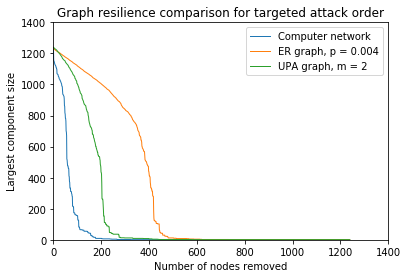

In [6]:
# QUESTION 4
# To continue our analysis of the computer network, we will examine its resilience under an attack in which servers are chosen based on their connectivity.
# We will again compare the resilience of the network to the resilience of ER and UPA graphs of similar size.
# Using 'targeted_order' (or fast_targeted_order), your task is to compute a targeted attack order for each of the three graphs (computer network, ER, UPA) from Question 1. Then, for each of these three graphs, compute
# the resilience of the graph using 'compute_resilience'. Finally, plot the computed resiliences as three curves (line plots) in a single standard plot. As in Question 1, please include a legend in your plot that distinguishes the three plots.
def run_question_4():
    computer_network = (load_graph(NETWORK_URL))
    total_nodes = len(computer_network)  # 1239
    total_edges = compute_edges(computer_network)  # 3047
    p = 0.004
    m = 2
    plots = [(computer_network, "Computer network"), (random_ugraph(total_nodes, p), "ER graph, p = " + str(p)), (UPA(total_nodes, m), "UPA graph, m = " + str(m))]

    for graph, label_on_plot in plots:
        y = pro2.compute_resilience(graph, targeted_order_fast(graph))  # since the 'compute_resilience' procedure already outputs the correct order we don't really have to do anything extra
        plt.plot(y, linewidth=1, label=label_on_plot)

    plt.title("Graph resilience comparison for targeted attack order")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("Largest component size")
    plt.axis([0, 1400, 0, 1400])
    plt.legend()
    plt.show()  # this plot will show us that for three similar graphs (same no. of nodes and edges) the resilience of the graph is alike

run_question_4()

# In general, the resilience for all three graphs should drop towards zero very quickly with the ER graph being most resilient and the computer network being least resilient. If the submitted plot for the m=3
# UPA curve is shifted significantly to the left and instead looks like the solution plot for the m=2 UPA curve, score that curve as being incorrect since this shift indicates that incorrect probabilities were used
# in computing the UPA graph

Loaded graph with 1239 nodes
The biggest connected components after removal of 20% of nodes, with 992 nodes remaining: [4, 923, 28]
The % of connected components removed after removal of 20% of nodes: ['0%', '93%', '3%']


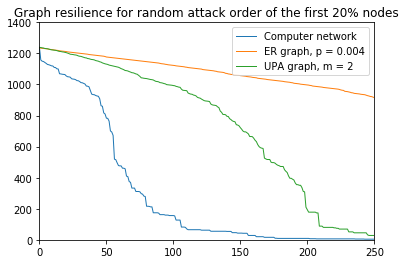

In [7]:
# QUESTION 5
# Now, consider removing a significant fraction of the nodes in each graph using 'targeted_order'. Examine the shape of the three curves from your plot in Question 4. Which of the three graphs are resilient under targeted
# attacks as the first 20% of their nodes are removed? Again, note that there is no need to compare the three curves against each other in your answer to this question.
def run_question_5():
    plt.title("Graph resilience for random attack order of the first 20% nodes")
    computer_network = (load_graph(NETWORK_URL))
    total_nodes = len(computer_network)  # 1239
    proc20 = total_nodes / 5  # 247
    nodes_remaining = total_nodes - proc20
    plt.axis([0, 250, 0, 1400])
    p = 0.004
    m = 2

    highest_cc = []
    plots = [(computer_network, "Computer network"), (random_ugraph(total_nodes, p), "ER graph, p = " + str(p)), (UPA(total_nodes, m), "UPA graph, m = " + str(m))]

    for graph, label_on_plot in plots:
        data = (pro2.compute_resilience(graph, targeted_order_fast(graph)))  # since the 'compute_resilience' procedure already outputs the correct order we don't really have to do anything extra
        highest_cc.append(data[proc20])
        plt.plot(data, linewidth=1, label=label_on_plot)

    print "The biggest connected components after removal of 20% of nodes, with", nodes_remaining, "nodes remaining:", highest_cc
    print "The % of connected components removed after removal of 20% of nodes:", ["{0:.0%}".format(cc / float(nodes_remaining)) for cc in highest_cc]  # values must be ~equal to the number of nodes remaining
    plt.legend()
    plt.show()

run_question_5()

# As per calculated data below, the 'computer network' and 'UPA' graphs are not resilient (highest component loss went above 25%). The 'ER' graph is resilient under targeted attack.
# For ['computer network', 'ER', 'UPA']
# The biggest connected components after removal of 20% of nodes, with 992 nodes remaining: [4, 940, 39]
# The % of connected components removed after removal of 20% of nodes: ['0%', '95%', '4%']